In [221]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## 数据集读取
- Mnist数据是图像数据：(28,28,1)的灰度图

In [222]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784",version=1,cache=True)
mnist.target = mnist.target.astype(np.int64)
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0           0       0       0       0       0       0       0       0       0   
 1           0       0       0       0       0       0       0       0       0   
 2           0       0       0       0       0       0       0       0       0   
 3           0       0       0       0       0       0       0       0       0   
 4           0       0       0       0       0       0       0       0       0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995       0       0       0       0       0       0       0       0       0   
 69996       0       0       0       0       0       0       0       0       0   
 69997       0       0       0       0       0       0       0       0       0   
 69998       0       0       0       0       0       0       0       0       0   
 69999       0       0       0       0       0       0       0       0       0   
 
      

In [223]:
X,y = mnist["data"],mnist["target"]
X_train, X_test, y_train, y_test = X[:60000].values, X[60000:].values, y[:60000].values, y[60000:].values

In [224]:
## 洗牌操作
shuffle_index = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 交叉验证代码实现

In [225]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [226]:
y_train_5[:10]

array([False, False, False, False, False, False, False, False,  True,
       False])

In [227]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [228]:
sgd_clf.predict([X.values[35000]])

array([False])

In [229]:
y[35000]

np.int64(1)

In [230]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv = 3,scoring="accuracy")

array([0.964 , 0.9579, 0.9571])

In [231]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skflods = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
for train_index, test_index in skflods.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = (y_pred == y_test_folds)
    print(n_correct/len(y_pred))

[5.e-05 5.e-05 5.e-05 ... 5.e-05 5.e-05 5.e-05]
[5.e-05 5.e-05 5.e-05 ... 5.e-05 5.e-05 5.e-05]
[5.e-05 5.e-05 5.e-05 ... 5.e-05 5.e-05 5.e-05]


## 混淆矩阵

In [232]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)

In [233]:
y_train_pred.shape

(60000,)

In [234]:
X_train.shape

(60000, 784)

In [235]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[54058,   521],
       [ 1899,  3522]])

negative class[[true negatives, false positives],

positive class[false negatives, true positives]]

## 获取查全率，查准率,F1

In [236]:
from sklearn.metrics import precision_score, recall_score, f1_score
## 查准率
precision_score(y_train_5, y_train_pred)

np.float64(0.8711352955725946)

In [237]:
## 查全率
recall_score(y_train_5, y_train_pred)

np.float64(0.6496956281128943)

In [238]:
## F1
f1_score(y_train_5,y_train_pred)

np.float64(0.7442941673710904)

## 阈值对结果的影响

In [239]:
## 阈值对结果的影响
y_scores = sgd_clf.decision_function([X.values[35000]])
y_scores

array([-232764.96231592])

In [243]:
t = 0
y_pred = (y_scores > t)
y_pred

array([False])

## 自动判断阈值

In [244]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [248]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

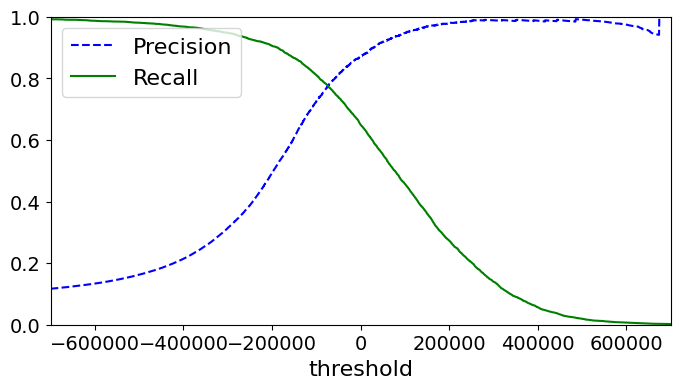

In [249]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(
        thresholds,
        precisions[:-1],
        "b--",
        label="Precision"
    )
    
    plt.plot(
        thresholds,
        recalls[:-1],
        "g-",
        label="Recall"
    )
    
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls,thresholds)
plt.xlim([-700000, 700000])
plt.show()

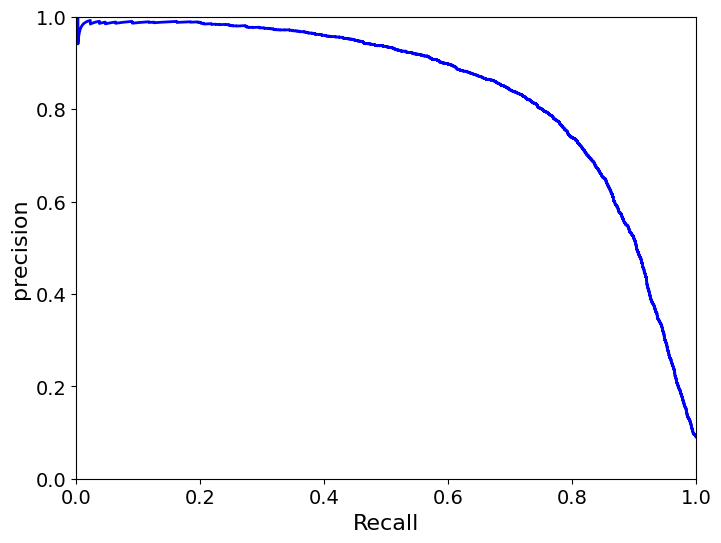

In [251]:
def plot_precision_recall(precisions, recalls):
    plt.plot(
        recalls,
        precisions,
        "b-",
        linewidth=2
    )
    
    plt.xlabel("Recall",fontsize=16)
    plt.ylabel("precision",fontsize=16)
    plt.axis([0,1,0,1])

plt.figure(figsize=(8,6))
plot_precision_recall(precisions, recalls)
plt.show()

## ROC 曲线

In [265]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

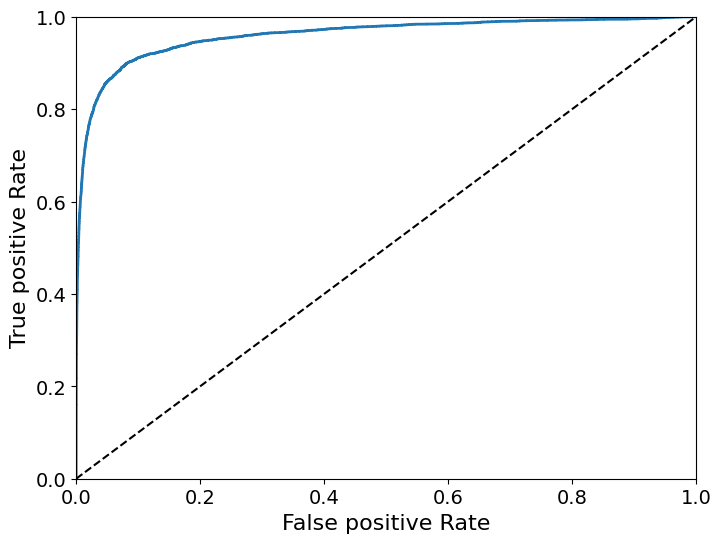

In [264]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1],[0,1],"k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False positive Rate", fontsize=16)
    plt.ylabel("True positive Rate", fontsize=16)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [267]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9598058535696421)